In [399]:
import gym
import torch
import gym
import random
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

from common import *
from multiprocessing import Pool
from itertools import repeat
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import eigs

env_name = "Hopper-v2"
post_names = ['madodiv', 'mdim_div']


from collections import namedtuple

class MeshBox:
    def __init__(self, state, iden, freq, trans_list):
        self.state = state
        self.id = iden
        self.freq = freq
        self.trans_list = trans_list

def my_reset(env, point):
    env.reset()
    qpos = np.concatenate((np.array([0.0]), point[:5]))
    qvel = point[5:]
    env.unwrapped.set_state(qpos, qvel)
    return env.unwrapped._get_obs()

def fail_cond(ob):
    #tilted = np.abs(ob[:,1]) > .2 
    short = ob[:,0] < .7
    #return np.logical_or(tilted, short)
    return short


def do_monte_carlo_rollout(arg):
    env, policy = arg
    torch.autograd.set_grad_enabled(False)
    act_list = []
    obs_list = []
    rew_list = []
    x_list = []

    dtype = torch.float32
    init_obs = env.reset()
    done = False
    obs_size = env.observation_space.shape[0]
    act_size = env.action_space.shape[0]

    step_count = 0
    
    while not done:        
        angs = np.random.uniform(0,2*np.pi,1)
        mags = np.random.uniform(5,15,1) 
        force_x = np.cos(angs)*mags
        force_y = np.sin(angs)*mags

        if step_count <= 1:
            force = (0,0)
        else:
            force = (force_x, force_y)
        obs, acts, rews, _ = do_push_rollout_from_state(env, policy, init_obs, force)
        peak_idx,_ = find_peaks(obs[:,0], distance=20)
        
        if len(peak_idx) != 1 or fail_cond(obs[:peak_idx[0]]).any():
            done = True
        else:
            #print(f"step was good, count: {step_count}")
            step_count +=1
            init_obs = obs[peak_idx[0],:]

    torch.autograd.set_grad_enabled(True)
    return step_count


def do_push_rollout_from_state(env, policy, init_state, force, num_steps=100, force_steps = 1, render=False):
    torch.autograd.set_grad_enabled(False)
    act_list = []
    obs_list = []
    rew_list = []
    x_list = []

    dtype = torch.float32
    obs = my_reset(env, init_state)
    done = False
    obs_size = env.observation_space.shape[0]
    act_size = env.action_space.shape[0]

    for cur_step in range(num_steps):
        if render:
            env.render()
            time.sleep(.01)
        
        obs = torch.as_tensor(obs, dtype=dtype).detach()
        #obs += torch.randn(obs_size)*obs_std
        obs_list.append(obs.clone())
        
        x_list.append(env.unwrapped.sim.data.qpos[0])
        
        if cur_step < force_steps:
            env.unwrapped.sim.data.xfrc_applied[1,:] = np.array([force[0],0,force[1],0,0,0])
        else:
            env.unwrapped.sim.data.xfrc_applied[1,:] = np.zeros(6)

        
        act = policy(obs)
        #act += torch.randn(act_size)*act_std
        obs, rew, done, _ = env.step(act.numpy())
        
        act_list.append(torch.as_tensor(act.clone()))
        rew_list.append(rew)
        
    ep_length = len(rew_list)
    ep_obs = torch.stack(obs_list)
    ep_act = torch.stack(act_list)
    ep_rew = torch.tensor(rew_list, dtype=dtype)
    ep_rew = ep_rew.reshape(-1, 1)

    torch.autograd.set_grad_enabled(True)
    return ep_obs, ep_act, ep_rew, x_list


def do_explore_rollout(args):
    force, init_state, trial_num = args
    env.seed(trial_num)
    np.random.seed(trial_num)
    torch.manual_seed(trial_num)
    
    env.seed(trial_num)
    obs, acts, rews, x_list = do_push_rollout_from_state(env, policy, init_state, force)    
    
    return np.asarray(obs)

In [2]:
env = gym.make(env_name)
data = torch.load(f"./data_noise1/{env_name}.xr")
#data = torch.load(f"./data17/{env_name}.xr")

init_policy_dict = data.policy_dict

data = torch.load(f"./data_noise1_mdim/{env_name}.xr")
#data = torch.load(f"./data_mcshdim4/{env_name}.xr")
policy_dict = data.policy_dict
policy_dict['identity'] = init_policy_dict['identity']
policy_dict['madodiv'] = init_policy_dict['madodiv']

running build_ext


In [3]:
def construct_reachable_mesh(env, policy, forces, delta, n_workers=12, verbose=True):
    
    mesh = BoxMesh(delta); mdim_l = []


    fail_state = np.ones_like(env.reset())*100
    fail_id = 0
    mesh[fail_state] = MeshBox(fail_state, 0, 1, [])

    obs, acts, rews, _ = do_long_rollout(env, policy, ep_length=1000)
    peak_idx,_ = find_peaks(obs[:,0], distance=20)


    for o in obs[peak_idx[2:],:]:
        key = (o - policy.state_means)/policy.state_std

        if key in mesh:
            mesh[key].freq +=1
        else:
            mesh[key] =  MeshBox(o, len(mesh), 1, [])
            
    start = time.time()
    keys = list(mesh.keys())[1:]
    i = 0 

    with Pool(12, maxtasksperchild=1000) as pool:
        for init_key in keys:    
            i+=1 

            init_state = mesh[init_key].state
            state_iter = repeat(init_state, n_forces)
            seeds_iter = range(i*n_forces, i*n_forces+n_forces)

            for j, res in enumerate(pool.imap(do_explore_rollout, zip(force_iter, state_iter, seeds_iter))):
                obs = res

                peak_idx,_ = find_peaks(obs[:,0], distance=20)

                if len(peak_idx) != 1 or fail_cond(obs[:peak_idx[0]]).any():
                    new_id = fail_id
                    mesh[fail_state].freq +=1
                else:
                    new_key = ((obs[peak_idx,:] - np.array(policy.state_means))/np.array(policy.state_std)).squeeze()
                    if new_key in mesh:
                        new_id = mesh[new_key].id
                        mesh[new_key].freq += 1
                    else:
                        mesh[new_key] = MeshBox(obs[peak_idx, :].squeeze(), len(mesh), 1, [])
                        new_id = len(mesh)-1
                        keys.append(mesh.__keytransform__(new_key))

                mesh[init_key].trans_list.append(new_id)


            if i % 1000 == 0 and verbose:
                print(f"i; {i}, mdim: {len(keys)}, ratio: {i/len(keys)}")
                #print(f"i; {i}, iden: {len(iden_mesh)}, mdim: {len(mdim_mesh)}, ratio: {len(mdim_mesh)/len(iden_mesh)}")

    return mesh

In [4]:
n_forces = 101
angs = np.random.uniform(0,2*np.pi,n_forces)
mags = np.random.uniform(5,15,n_forces) 
forces_x = np.cos(angs)*mags
forces_y = np.sin(angs)*mags
force_iter = [np.array([fx,fy]) for fy,fx in zip(forces_x, forces_y)]

In [ ]:
seed = 0; 
policy = policy_dict['mdim_div'][seed]
#mfpt_list = [] 
#w_list = []
#mesh_list = []
#box_sizes = np.logspace(-2, -1, 10):

for box_size in [.005]:
        mesh = construct_reachable_mesh(env, policy, force_iter, delta=box_size)
        T = lil_matrix((len(mesh), len(mesh)))

        T[0,0] = 1
        for box in mesh.values():
            for trans_id in box.trans_list:
                T[box.id, trans_id] += 1/len(box.trans_list)

        w, v = eigs(T.conjugate(),10)
        w.sort()
        print(w)
        print(-1/np.log(w[-2]))
        
        w_list.append(w)
        mfpt_list.append(-1/np.log(w[-2]))
        mesh_list.append(mesh)

i; 1000, mdim: 36872, ratio: 0.02712085050987199
i; 2000, mdim: 51499, ratio: 0.03883570554768054
i; 3000, mdim: 61637, ratio: 0.048672063857747784
i; 4000, mdim: 68421, ratio: 0.058461583431987256
i; 5000, mdim: 76923, ratio: 0.065000065000065
i; 6000, mdim: 87628, ratio: 0.06847126489250012
i; 7000, mdim: 94553, ratio: 0.07403255317123729
i; 8000, mdim: 100379, ratio: 0.07969794478924874
i; 9000, mdim: 104877, ratio: 0.08581481163648846
i; 10000, mdim: 108453, ratio: 0.09220584031792574
i; 11000, mdim: 112153, ratio: 0.09808030101736022
i; 12000, mdim: 114968, ratio: 0.10437687008558903
i; 13000, mdim: 117633, ratio: 0.11051320632815621
i; 14000, mdim: 119996, ratio: 0.11667055568518951
i; 15000, mdim: 121920, ratio: 0.12303149606299213
i; 16000, mdim: 123964, ratio: 0.12906972992159013
i; 17000, mdim: 125579, ratio: 0.13537295248409367
i; 18000, mdim: 127271, ratio: 0.14143049084237572
i; 19000, mdim: 128940, ratio: 0.14735535908174344
i; 20000, mdim: 130504, ratio: 0.15325200760129

Text(0, 0.5, 'Mesh State From')

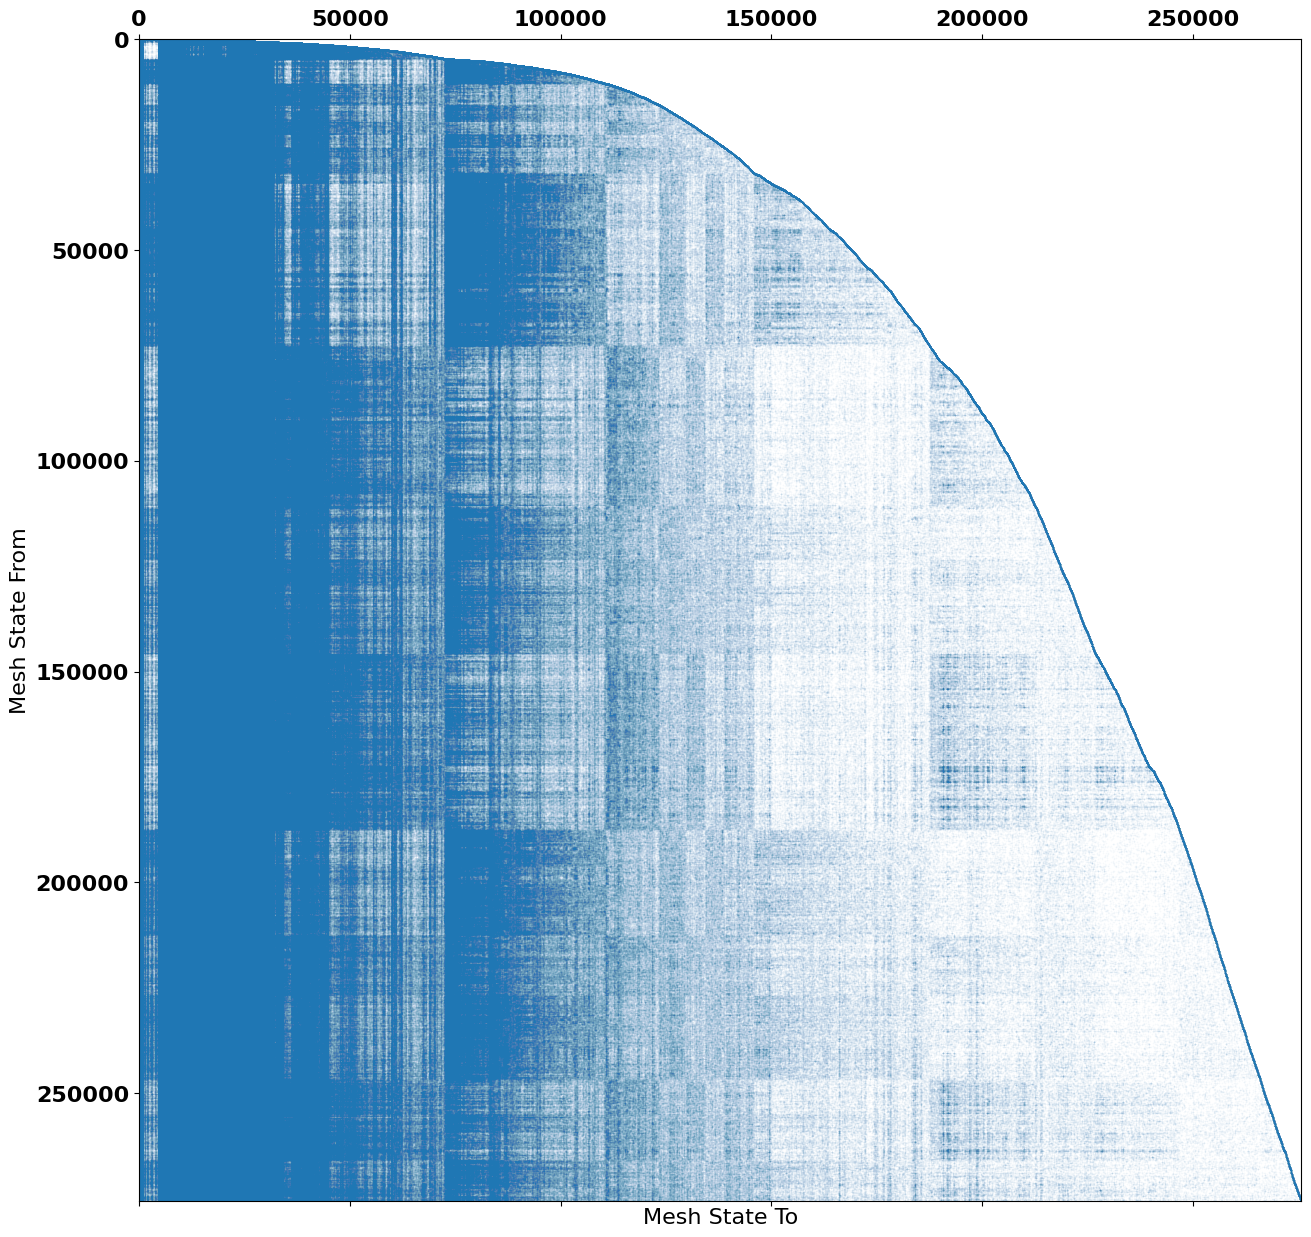

In [357]:
#plt.spy(T, markersize=4, figsize=(15,20))
fig, ax = plt.subplots(1, figsize=(15,20))
ax.spy(T, markersize=.1, alpha=.1)
plt.xlabel("Mesh State To")
plt.ylabel("Mesh State From")


In [406]:
mfpt_list2.reverse()

In [400]:
from multiprocessing import Pool
from itertools import repeat


n_trials = 2500
data = []
with Pool(12, maxtasksperchild=1000) as pool:
        env_iter = repeat(env, n_trials)
        pol_iter = repeat(policy_dict['mdim_div'][0])
        for i, res  in enumerate(pool.imap(do_monte_carlo_rollout, zip(env_iter, pol_iter))):
            steps = res
            data.append(steps)
 

88.1748
86.15040478697706
177


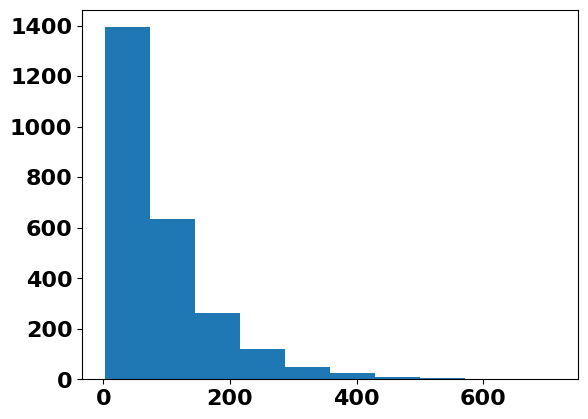

In [402]:
data = np.array(data)
print(data.mean())
print(data.std())
plt.hist(data)
print(data[int(data.shape[0]/2)])    

/home/sgillen/anaconda3/envs/baselines/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


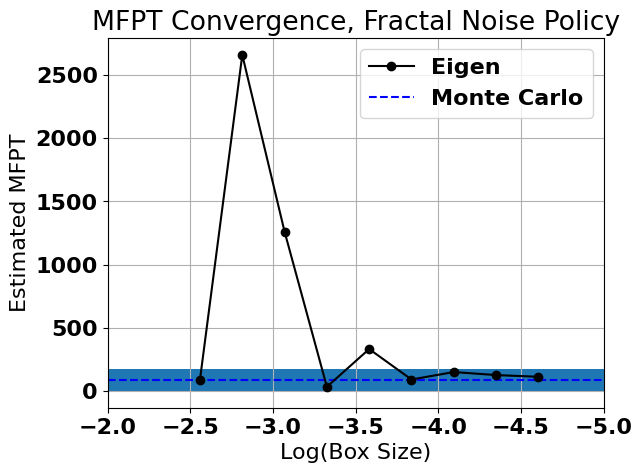

In [412]:
import matplotlib
matplotlib.style.use('default')

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16}

matplotlib.rc('font', **font)

matplotlib.rc('font', **font)
p_boxes = list(box_sizes)
p_boxes.reverse()

fig, ax = plt.subplots(1)

ax.plot(np.log(p_boxes)[1:], mfpt_list2[2:], 'o-', color='k')
plt.xlabel('Log(Box Size)')
plt.ylabel('Estimated MFPT')
ax.invert_xaxis()
plt.ylabel('Estimated MFPT')
#plt.hlines(90, 0, 10, linestyle='dashed')
#ax.hlines(80 + 80, -2.2, -4, linestyle='dashed', color='blue')
ax.hlines(data.mean(), -2, -6, linestyle='dashed', color='blue')
#ax.hlines(80 +- 80, -2.2, -4, linestyle='dashed', color='blue')

#ax.hlines(0, -2, -5, linestyle='solid', color='blue')
#ax.hlines(160, -2, -5, linestyle='solid', color='blue')

dummy_x = np.linspace(-1, -6, 100)

plt.fill_between(dummy_x, data.mean() - data.std() , data.mean() + data.std())

plt.title("MFPT Convergence, Fractal Noise Policy")
plt.legend(['Eigen', 'Monte Carlo'])
plt.xlim(-2,-5)

plt.grid()

In [256]:
import matplotlib
matplotlib.style.use('default')

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16}

matplotlib.rc('font', **font)
p_boxes = list(box_sizes)
p_boxes.reverse()

fig, ax = plt.subplots(1)

ax.plot(p_boxes, mfpt_list[1:], 'o--', color='k')
ax.invert_xaxis()
#plt.hlines(90, 0, 10, linestyle='dashed')
#ax.hlines(80, -2.2, -5, linestyle='dashed', color='blue')
#plt.ylim(0,150)

#plt.title

Signature: plt.xlabel(xlabel, fontdict=None, labelpad=None, **kwargs)
Docstring:
Set the label for the x-axis.

Parameters
----------
xlabel : str
    The label text.

labelpad : scalar, optional, default: None
    Spacing in points from the axes bounding box including ticks
    and tick labels.

Other Parameters
----------------
**kwargs : `.Text` properties
    `.Text` properties control the appearance of the label.

See also
--------
text : for information on how override and the optional args work
Source:   
@docstring.copy(Axes.set_xlabel)
def xlabel(xlabel, fontdict=None, labelpad=None, **kwargs):
    return gca().set_xlabel(
        xlabel, fontdict=fontdict, labelpad=labelpad, **kwargs)
File:      ~/anaconda3/envs/baselines/lib/python3.6/site-packages/matplotlib/pyplot.py
Type:      function


In [39]:
from multiprocessing import Pool
from itertools import repeat

sample_means = []
sample_stds =  []

n_samples = 25
for i in range(n_samples):

    n_trials = 25
    data = []
    with Pool(12, maxtasksperchild=1000) as pool:
            env_iter = repeat(env, n_trials)
            pol_iter = repeat(policy_dict['mdim_div'][0])
            for i, res  in enumerate(pool.imap(do_monte_carlo_rollout, zip(env_iter, pol_iter))):
                steps = res
                data.append(steps)
            sample_means.append(np.array(data).mean())
            sample_stds.append(np.array(data).std())
    
    
plt.hist(sample_means,bins=50)
np.array(sample_means).mean()

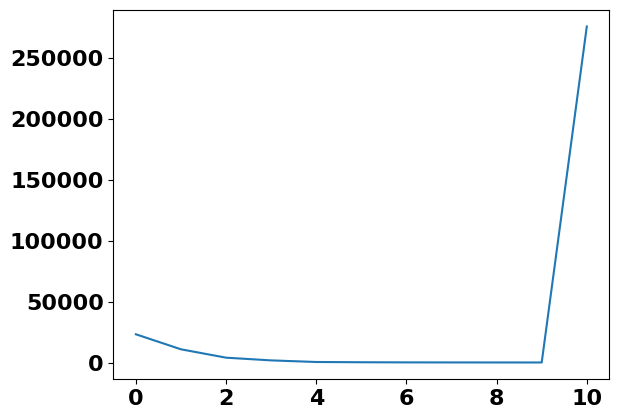

In [314]:
from numpy import *
mesh_sizes = [len(m) for m in mesh_list]
plt.plot(mesh_sizes)

In [62]:
import dill
with  open("meshes_f1/mdim0_noise_10k.pkl", 'wb') as file:
   dill.dump(mesh, file)

/home/sgillen/anaconda3/envs/baselines/lib/python3.6/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


In [12]:
np.linspace(.1, .025, 10)

array([0.1       , 0.09166667, 0.08333333, 0.075     , 0.06666667,
       0.05833333, 0.05      , 0.04166667, 0.03333333, 0.025     ])

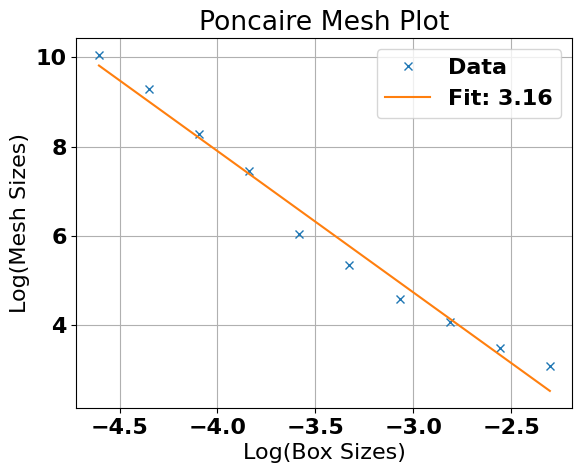

In [297]:
mesh_sizes = [len(m) for m in mesh_list]
plt.plot(np.log(box_sizes), np.log(mesh_sizes)[:-1], 'x')

import scipy.optimize as opt

# Fit a curve to the log log line
def f(x, m, b):
    return m * x + b

xdata = np.log(box_sizes)
ydata = np.log(mesh_sizes)[:-1]
popt, pcov = opt.curve_fit(f, xdata, ydata)

plt.plot(xdata, popt[0]*xdata + popt[1])
plt.legend(['Data',f'Fit: {-popt[0]:.2f}'])
plt.title('Poncaire Mesh Plot')
plt.xlabel('Log(Box Sizes)')
plt.ylabel('Log(Mesh Sizes)')
plt.grid()

In [156]:
print(np.log(box_sizes))
print(xdata)
print(popt[0])

[-4.60517019 -4.3493274  -4.09348461 -3.83764182 -3.58179903 -3.32595625
 -3.07011346 -2.81427067 -2.55842788 -2.30258509]
[-4.60517019 -4.3493274  -4.09348461 -3.83764182 -3.58179903 -3.32595625
 -3.07011346 -2.81427067 -2.55842788 -2.30258509]
-3.162159984027706


In [121]:
obs,acts,rews,_ = do_long_rollout(env, policy,ep_length=10000)

ldim, udim, traj_m_sizes, d_vals =  mesh_dim(obs)

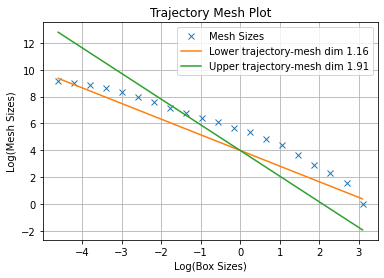

In [208]:
plt.plot(np.log(d_vals), np.log(traj_m_sizes), 'x')
plt.plot(np.log(d_vals), np.log(d_vals)*-ldim + 4)
plt.plot(np.log(d_vals), np.log(d_vals)*-udim + 4)

plt.legend(["Mesh Sizes", f"Lower trajectory-mesh dim {ldim:.2f}", f"Upper trajectory-mesh dim {udim:.2f}"])
plt.title('Trajectory Mesh Plot')
plt.xlabel('Log(Box Sizes)')
plt.ylabel('Log(Mesh Sizes)')
plt.grid()

In [319]:
mfpt_list2 = [1/(1-w[-2]) for w in w_list]

In [322]:
mfpt_list2.reverse()

In [410]:
mfpt_list2

[(111.11845628435155+0j),
 (-4503599627370496-0j),
 (91.69355345507482+0j),
 (2656.5317430492137+0j),
 (1260.1571298316776+0j),
 (34.49401582178981+0j),
 (332.86643001400836+0j),
 (92.23054319165774+0j),
 (151.10077301678783+0j),
 (127.27733673826145+0j),
 (113.79854518438263+0j)]

In [334]:
mesh_sizes2 = [95516, 37187, 24816, 10250, 6679, 2736, 1526, 713, 436, 157]
box_sizes2 = np.array([0.01995262, 0.0238659 , 0.02854668, 0.03414549, 0.04084239, 0.04885274, 0.05843414, 0.06989473, 0.08360307, 0.1])

Text(0, 0.5, 'Mesh Size')

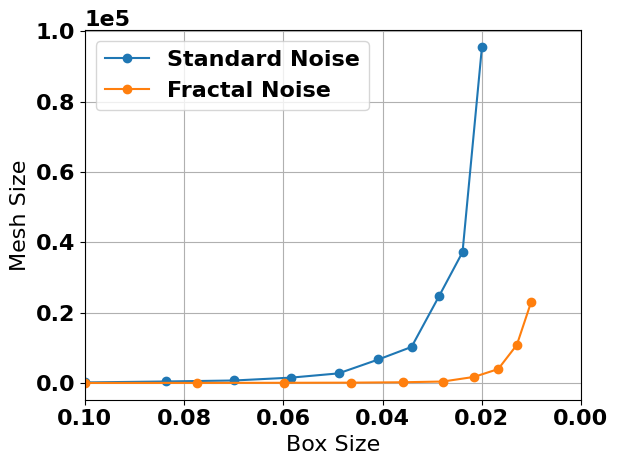

In [391]:
plt.plot(box_sizes2, mesh_sizes2, 'o-')
plt.plot(box_sizes3[1:], mesh_sizes3[1:], 'o-')
plt.xlim(.1, 0)
plt.grid()
plt.ticklabel_format(style='scientific', scilimits=(-5,1))
plt.legend(['Standard Noise', 'Fractal Noise'])
plt.xlabel("Box Size")
plt.ylabel("Mesh Size")

In [345]:
box_sizes
mesh_sizes3

[275658, 23150, 10830, 3954, 1731, 419, 209, 99, 59, 33, 22]

In [341]:
mesh_sizes3 = []
mesh_sizes3.append(mesh_sizes[-1])
[mesh_sizes3.append(m) for m in mesh_sizes[:-1]]
mesh_sizes3

[275658, 23150, 10830, 3954, 1731, 419, 209, 99, 59, 33, 22]

In [349]:
box_sizes3 = [.005] + list(box_sizes)

In [388]:
box_sizes

array([0.01      , 0.0129155 , 0.01668101, 0.02154435, 0.02782559,
       0.03593814, 0.04641589, 0.05994843, 0.07742637, 0.1       ])

In [390]:
mesh_sizes3

[275658, 23150, 10830, 3954, 1731, 419, 209, 99, 59, 33, 22]

In [393]:
with 

275658

In [394]:
import dill
with  open("meshes_f2/mdim0_noise_100k.pkl", 'wb') as file:
    dill.dump(mesh, file)

/home/sgillen/anaconda3/envs/baselines/lib/python3.6/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)
